In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
data = pd.read_excel('Online_Retail.xlsx')
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [3]:
#Step 3: Data Cleaning
# Drop rows with missing CustomerID
data.dropna(subset=['CustomerID'], inplace=True)

# Remove negative or zero Quantity and UnitPrice
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Create TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [4]:
#Step 4: RFM Feature Engineering
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


In [5]:
# ⚙️ Step 5: Feature Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

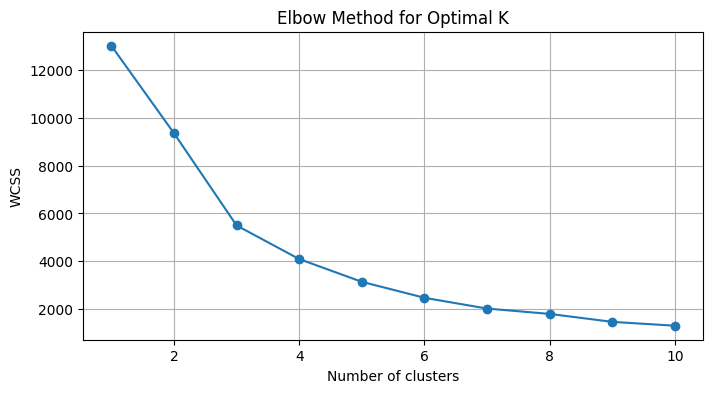

In [6]:
# 📉 Step 6: Elbow Method to find optimal clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [7]:
# 🤖 Step 7: KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [8]:
# 🏷️ Step 8: Label Clusters (optional - based on business logic)
cluster_map = {
    0: 'Loyal Customers',
    1: 'At-Risk Customers',
    2: 'New Customers',
    3: 'Big Spenders'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_map)

In [9]:
# 📊 Step 9: Cluster Profiling
cluster_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'})

print(cluster_summary)

                      Recency  Frequency       Monetary  Num_Customers
Segment                                                               
At-Risk Customers  248.075914   1.552015     480.617480           1067
Big Spenders        15.500000  22.333333   12709.090490            204
Loyal Customers     43.702685   3.682711    1359.049284           3054
New Customers        7.384615  82.538462  127338.313846             13


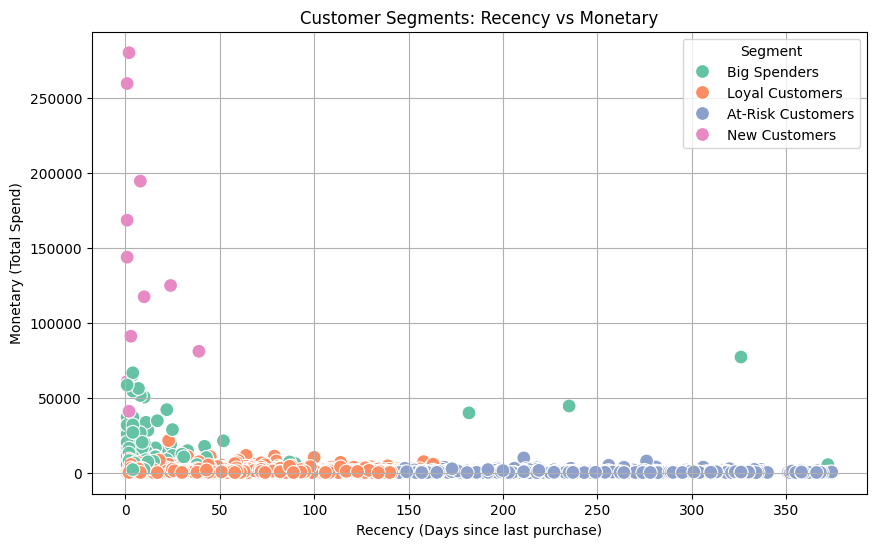

In [10]:
# 📈 Step 10: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set2', s=100)
plt.title('Customer Segments: Recency vs Monetary')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Monetary (Total Spend)')
plt.grid()
plt.show()

In [ ]:
# 💾 Step 11: Save results
rfm.to_csv("rfm_segmented_customers.csv", index=False)

In [1]:
# 📌 (Optional) Step 12: Marketing Strategy Suggestions
print("\n📊 Suggested Marketing Strategies:")
strategies = {
    'Loyal Customers': 'Reward with loyalty programs and early access',
    'Big Spenders': 'Upsell premium products, exclusive offers',
    'New Customers': 'Welcome series, onboarding emails',
    'At-Risk Customers': 'Win-back campaigns and discounts'
}

for segment, strategy in strategies.items():
    print(f"- {segment}: {strategy}")


📊 Suggested Marketing Strategies:
- Loyal Customers: Reward with loyalty programs and early access
- Big Spenders: Upsell premium products, exclusive offers
- New Customers: Welcome series, onboarding emails
- At-Risk Customers: Win-back campaigns and discounts
